In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
from useful_functions import read_in_election_results, calc_marginal_within
from useful_functions import score_campaigns_difference, score_campaigns_uns,score_campaigns_mrp
from useful_functions import read_in_census

## Score constituencies

Read in election results and calculate various scoring metrics for the labour campaing in each constituency

- `base` : Simply the % share of votes Labour recieved in a constituency
- `diff` : Difference in number of votes between an election year and the comparisson year
- `uns` : Swing to/from labour in a constituency minus the national average swing
- `mrp` : Compare the Labour vote share with the YOUGOV MRP poll carried out 4 weeks before an election, only available for GE17 and GE19



In [3]:
election_results = read_in_election_results() 

In [4]:
#Pick year of interest, and one to compare with (neccesary for some of the scoring methods)
year = 19 # 2019 election
compare_year = 17 # normally the previous election year

In [5]:
base = pd.DataFrame(election_results[year]['lab_pc'],
                    index=election_results[year].index)

diff = score_campaigns_difference(election_results[year], 
                                  election_results[compare_year])

uns  = score_campaigns_uns(election_results[year], 
                           election_results[compare_year])

mrp  = score_campaigns_mrp(election_results[year])

In [6]:
# Compile all scoring metrics into one database `scores`
scores = pd.concat( [election_results[year]['Constituency'],
                     base['lab_pc'], diff['difference'],uns['difference'],mrp['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','base','diff','uns','mrp']
scores.sort_values('uns',ascending=False).head()

,Constituency,base,diff,uns,mrp
E14000589,Bradford West,0.762206,4292.0,0.194483,0.222206
E14000884,Portsmouth South,0.486410,4778.0,0.155008,0.066410
E14000958,Southport,0.389518,3140.0,0.142657,0.079518
E14000780,Leeds North West,0.486395,3555.0,0.124321,-0.003605
E14000887,Putney,0.451384,3655.0,0.122549,0.111384


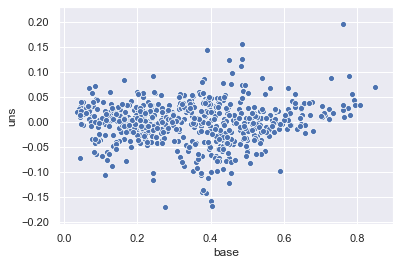

In [7]:
ax = sns.scatterplot(scores['base'],scores['uns'])

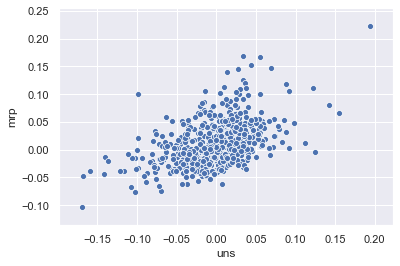

In [8]:
sns.scatterplot(scores['uns'],scores['mrp'])

In [9]:
# seats that labour won by, or were within a certain percentage of winning
marginals = calc_marginal_within(0.10,election_results[compare_year])

## Select demographic data to compare constituencies

In [10]:
census = read_in_census()
# only want rows we have election data for
census = census.loc[election_results[year].index]

In [11]:
features = ['c11PopulationDensity',
            'c11HouseOwned',
            'c11CarsNone',
            'c11EthnicityWhite',
            'c11Unemployed',
            'c11Retired',
            'c11FulltimeStudent',
            'c11Age65to74',
            'c11DeprivedNone']

In [12]:
demographic_data = census[features]

In [13]:
# only want constituencies we have complete data for
demographic_data = demographic_data.dropna()
# Speaker seats have incomplete voting data
speaker_seats = census.index[census['constituency_name'].isin(['Chorley', 'Buckingham'])]
demographic_data = demographic_data.drop(speaker_seats)

loss = set(census.index) - set(demographic_data.index)
print('Loss =',len(loss))

Loss = 79


In [14]:
# Make some lookup containers
constits_id = demographic_data.index
constits_name = list(census.loc[constits_id]['constituency_name'])
id_to_name = {id_:name for id_,name in zip(constits_id, constits_name)}
name_to_id = {name:id_ for id_,name in zip(constits_id, constits_name)}
id_to_index = {onsid:i for i,onsid in enumerate(constits_id)}
name_to_index = {name:i for i,name in enumerate(constits_name)}

scores = scores.loc[constits_id] # only interested in these constits now

We can now see the spread of constituencies based on their demographics.

The graph below shows contituencies close to similar constituencies. Do not read too much into the axes. Points are coloured by their labour swing relative to the national labour swing.

In [15]:
#name_to_id

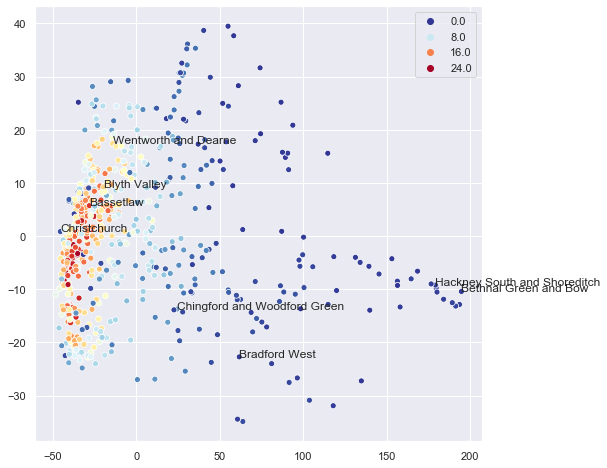

In [30]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)

X_transformed = embedding.fit_transform(demographic_data)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])

plt.figure(figsize=(8,8))
hues = np.array(marginals.loc[constits_id])
hues = np.array(scores['uns']-0.079) - 0.079
#hues = list(scores['base'])
hues = np.array(local_density['density'])
ax = sns.scatterplot(x=x,y=y,hue=hues, palette='RdYlBu_r')

for constit in ['Bethnal Green and Bow', 'Hackney South and Shoreditch','Christchurch',
               'Bradford West','Bassetlaw','Wentworth and Dearne','Blyth Valley','Chingford and Woodford Green']:
    ax.text(x[name_to_index[constit]], 
            y[name_to_index[constit]],
                        constit)

In [18]:
#from sklearn.decomposition import PCA
#from sklearn import preprocessing
#pca = PCA(n_components=2)
#X_transformed = pca.fit_transform(demographic_data)
#x_pca = pd.Series(X_transformed[:,0])
#y_pca = pd.Series(X_transformed[:,1])

#plt.figure(figsize=(6,6))
#hues = np.array(scores['uns']-0.079)
#hues *= 100
#hues = np.array(hues,dtype=int)
#hues = list(scores['base'])
#ax = sns.scatterplot(x=x_pca,y=y_pca,hue=hues, palette='RdYlBu_r')

#for constit in ['Chingford and Woodford Green']:
#    ax.text(x_pca[name_to_index[constit]], 
#            y_pca[name_to_index[constit]],
#                        constit)

##pd.DataFrame({f:c for f,c in zip(features,pca.components_[0])})
#for f,c in zip(features,pca.components_[0]):
#    print(f,c)
    

In [19]:
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances

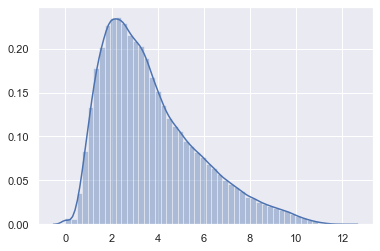

In [20]:
# Show distribution of distances between constituencies
X_scaled = preprocessing.scale(demographic_data)
dist_matrix = pairwise_distances(X_scaled)
sns.distplot(np.ndarray.flatten(dist_matrix))

In [21]:
scores['Constituency'].iloc[np.where(dist_matrix == np.max(dist_matrix))[0]]

ons_id
E14000638           Christchurch
E14000555    Bethnal Green & Bow
Name: Constituency, dtype: object

## Calculate confidence that a local campaign was succesful

All constituencies are compared with each other.

We calculate the 'distance' between each constituency according their demographics. Similar constituencies, based on the features chosen above, will have a small distance between them.

We then calculate the relative score between each campaign.

This relative score is divided by the distance between each constituency. Our confidence in a constituencies campaing is the sum of this value between all other constituencies.

If constituency A scored much better than constituency B, and they are very similar in demographics, A will recieve a positive contribution and B will recieve a negative one.

In [31]:
def distance(X, cutoff=None):
    return pairwise_distances(X)

def distance_cutoff(X, cutoff):
    dist_matrix = distance(X)
    mask = dist_matrix > cutoff
    dist_matrix[mask] = 0
    return dist_matrix

def distance_rescale(X, exponent=math.e):
    dist_matrix = distance(X)
    return exponent**dist_matrix
    
def calc_significance_matrix(demographic_data, constit_score, 
                             dist_func=distance, **kwargs):
    X_scaled      = preprocessing.scale(demographic_data)
    dist_matrix   = dist_func(X_scaled, **kwargs)
    constit_score = preprocessing.scale(constit_score)
    score_matrix  = constit_score[:,np.newaxis] - constit_score
    significance  = np.zeros(score_matrix.shape) # need to initialise all to zero
    np.divide( score_matrix, dist_matrix, where=dist_matrix!=0,
             out=significance)
    return significance
    
def calc_campaign_conf(demographic_data, constit_score, 
                             dist_func=distance, **kwargs):
    #assert np.all( demographic_data.index == constit_score.index )
    significance = calc_significance_matrix(demographic_data, constit_score, dist_func, **kwargs)
    return pd.Series(np.sum(significance,1),index=constits_id)

def calc_local_density(demographic_data, dist_func=distance, **kwargs):
    X_scaled      = preprocessing.scale(demographic_data)
    dist_matrix   = dist_func(X_scaled, **kwargs)
    local_density = np.zeros(dist_matrix.shape)
    np.divide(np.ones(dist_matrix.shape), dist_matrix, where=dist_matrix!=0,
             out=local_density)
    return pd.Series(np.sum(local_density,1),index=constits_id)

In [32]:
cutoff = 1
results = pd.DataFrame({
                        'constituency': constits_name,
                        'uns': calc_campaign_conf(demographic_data, scores['uns']),
                        'uns_cut': calc_campaign_conf(demographic_data, scores['uns'],distance_cutoff, cutoff=cutoff),
                        'uns_rescale': calc_campaign_conf(demographic_data, scores['uns'],distance_rescale, exponent=10),
                       }, index = constits_id)
results.head()

,constituency,uns,uns_cut,uns_rescale
ons_id,,,,
E14000754,Houghton and Sunderland South,-463.240381,-8.754477,-8.873928
E14000831,Newcastle Upon Tyne Central,17.886596,0.000000,0.013542
E14000832,Newcastle Upon Tyne East,5.107099,0.000000,-0.099379
E14000833,Newcastle Upon Tyne North,-86.876725,2.787251,-0.537045
E14000982,Sunderland Central,-207.788400,0.000000,-1.390275


In [35]:
local_density = calc_local_density(demographic_data,dist_func=distance_rescale,exponent=10)
local_density = pd.DataFrame({'constituency': constits_name,
                   'density': local_density})
results['density'] = local_density['density']
results['uns_rescale_normal'] = results['uns_rescale'] / local_density['density']
results.sort_values('uns_rescale_normal',ascending=False)

,constituency,uns,uns_cut,uns_rescale,density,uns_rescale_normal
ons_id,,,,,,
E14000958,Southport,903.505010,89.475386,36.502673,11.316953,3.225486
W07000078,Vale Of Glamorgan,582.989396,115.757242,32.312117,16.189147,1.995912
E14000762,Isle Of Wight,511.987872,51.232496,17.432359,8.751725,1.991877
E14000684,Eastbourne,435.393881,14.176463,15.510299,8.796621,1.763211
E14000735,Hastings and Rye,282.387991,58.475590,15.886840,9.060383,1.753440
E14000948,South Thanet,293.008591,54.067318,15.108348,8.985860,1.681347
E14001003,Truro and Falmouth,493.550945,8.164743,13.319244,7.958070,1.673678
W07000063,Montgomeryshire,503.844069,42.238572,19.011768,11.478559,1.656285
E14000634,Chingford and Woodford Green,471.587235,8.120976,6.136596,3.956471,1.551028


11.682102973812752

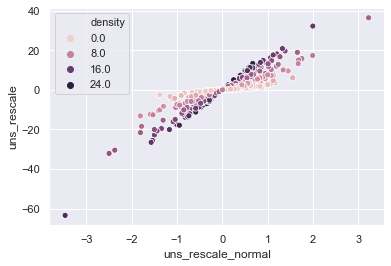

In [36]:
sns.scatterplot(y=results['uns_rescale'],x=results['uns_rescale_normal'],
                hue=results['density'])
#sns.distplot(results['uns_rescale_normal'])
#r2_score(results['uns_rescale'],results['uns_rescale_normal'])
results['uns_rescale'].std() / results['uns_rescale_normal'].std()

In [37]:
#results[results['constituency']=='Chingford and Woodford Green']

The following plot shows constituencies that according to this metric did well (red) or badly (blue). If a constituency is not similar to many others, the score is close to zero because we don't have much to compare to.

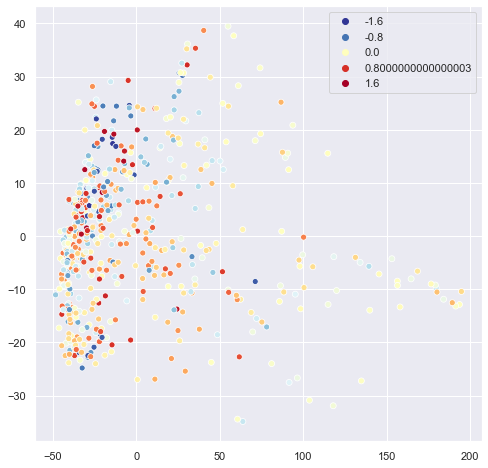

In [38]:
plt.figure(figsize=(8,8))
#sns.scatterplot(x=x,y=y,hue=np.tanh(np.array(results['uns_rescale'])/11.6), palette='RdYlBu_r')
sns.scatterplot(x=x,y=y,hue=np.tanh(np.array(results['uns_rescale_normal'])), palette='RdYlBu_r')

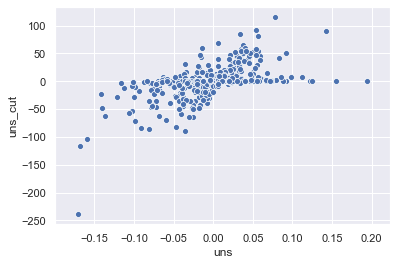

In [39]:
sns.scatterplot(x=scores['uns'],y=results['uns_cut'])

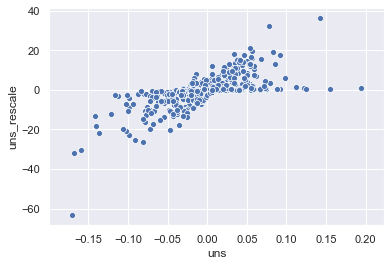

In [74]:
sns.scatterplot(x=scores['uns'],y=results['uns_rescale'])

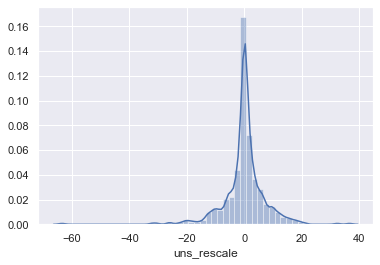

In [41]:
sns.distplot(results['uns_rescale'])

In [42]:
results.sort_values('uns_rescale',ascending=False)

,constituency,uns,uns_cut,uns_rescale,density,uns_rescale_normal
ons_id,,,,,,
E14000958,Southport,903.505010,89.475386,36.502673,11.316953,3.225486
W07000078,Vale Of Glamorgan,582.989396,115.757242,32.312117,16.189147,1.995912
E14000961,St Austell and Newquay,381.678226,91.580859,20.963145,15.805973,1.326280
E14000743,Hereford and South Herefordshire,409.267913,54.935082,19.701710,14.225731,1.384935
W07000063,Montgomeryshire,503.844069,42.238572,19.011768,11.478559,1.656285
E14000704,Folkestone and Hythe,276.722648,84.251337,18.237829,15.180728,1.201380
E14000614,Calder Valley,346.683503,50.834569,17.700726,15.765387,1.122759
E14000762,Isle Of Wight,511.987872,51.232496,17.432359,8.751725,1.991877
E14000682,East Worthing and Shoreham,385.633274,28.338278,16.812946,13.206271,1.273103


In [43]:
def list_similar(constit, N=5):
    index = id_to_index[constit]
    dists = dist_matrix[index]
    close_indexes = np.argsort(dists)
    
    df = pd.DataFrame({'name': id_to_name[constit],
                       'distance': 0},
                      index = [constit])

    for i in range(1,N+1):
        j = close_indexes[i]
        df = df.append( pd.DataFrame({'name': constits_name[j],
                                     'distance': dists[j]},
                                     index = [constits_id[j]])
                      )
    return df

In [44]:
def list_significances(constit, significance_matrix, scores, N=5):
    index = id_to_index[constit]
    dists = dist_matrix[index]
    significances = significance_matrix[index]
    most_signif = np.argsort(-abs(significances))

    df = pd.DataFrame({'name': id_to_name[constit],
                       'distance': 0,
                       'election swing': scores.loc[constit],
                       'score contribution': 0,
                       },
                      index = [constit])
    
    for i in range(N):
        j = most_signif[i]
        df = df.append( pd.DataFrame({'name': constits_name[j],
                                      'distance': dists[j],
                                      'election swing': scores[constits_id[j]] - 0.079,
                                      'score contribution': significances[j]
                                     },
                                     index = [constits_id[j]])
                      )
    return df

### Investigate a constituency's score

Define a constituency of interest `coi` in the cell below to see where it's score comes from.

In [45]:
# coi needs to a be an ONSID
coi = name_to_id['Vale Of Glamorgan']
coi = name_to_id['Chingford and Woodford Green']
#coi = name_to_id['Bassetlaw']
#coi = name_to_id['Bradford West']

In [49]:
significance_matrix = calc_significance_matrix(demographic_data, 
                                               scores['uns'], 
                                               distance_rescale, 
                                               exponent=10)
list_significances(coi, significance_matrix, scores['uns'],30)


,name,distance,election swing,score contribution
E14000634,Chingford and Woodford Green,0.000000,0.098182,0.000000
E14000621,Carshalton and Wallington,0.835257,-0.060568,0.273458
E14000599,Bristol East,0.921562,-0.075791,0.266964
E14000558,Bexleyheath and Crayford,0.898574,-0.060059,0.234851
E14000861,Northampton North,1.014040,-0.059552,0.178870
E14000692,"Enfield, Southgate",0.865352,-0.032195,0.164373
E14000650,Coventry North West,1.286576,-0.101381,0.146236
E14000548,Batley and Spen,1.374954,-0.128038,0.145689
E14000979,Stretford and Urmston,1.165341,-0.064737,0.134566
E14000711,Gillingham and Rainham,1.257432,-0.072091,0.118393


In [50]:
a = list_significances(name_to_id['Bradford West'],significance_matrix,scores['uns'])


In [51]:
list_similar(coi)

,name,distance
E14000634,Chingford and Woodford Green,0.000000
E14000621,Carshalton and Wallington,0.835257
E14000692,"Enfield, Southgate",0.865352
E14000558,Bexleyheath and Crayford,0.898574
E14000599,Bristol East,0.921562
E14000861,Northampton North,1.014040


In [52]:
# use these onsids to view in the separate notebook: show_constits.ipynb
list_similar(coi,30).index

Index(['E14000634', 'E14000621', 'E14000692', 'E14000558', 'E14000599',
       'E14000861', 'E14000636', 'E14000979', 'E14000900', 'E14000712',
       'E14000711', 'E14000984', 'E14001021', 'E14000604', 'E14000650',
       'E14000690', 'E14000552', 'E14000548', 'E14000883', 'E14000890',
       'E14000656', 'E14000779', 'E14000800', 'E14000600', 'E14000584',
       'E14000612', 'E14000969', 'W07000079', 'E14000759', 'E14000662',
       'E14001052'],
      dtype='object')

In [69]:
a =np.ndarray.flatten(significance_matrix)
b = a[abs(a)>0.2]
#sns.distplot(b)
#sns.scatterplot(x=a,y=np.ndarray.flatten(10**distance(preprocessing.scale(demographic_data))))#,exponent=10)))

This cell is meant to plot constituencies by demographics, then draw lines between constits that contribute to its result.

## Sensetivity Analysis

In [72]:
def sub_sample_features(features=features,subsample_size=1):
    from itertools import combinations
    return combinations(features,subsample_size)
    #return np.random.choice(features,subsample,replace=False)

def noise(array, factor=0.1):
    mean = np.mean(array, axis=0)
    std = np.std(array, axis=0)
    rng = np.random.RandomState()
    noise = rng.normal(mean, std * factor, size=array.shape)
    return array + noise

from sklearn.metrics import r2_score

df = results.copy()
print('Drop feature, r2_score')
for i,exclude in enumerate(sub_sample_features(subsample_size=1)):
    df[i] = calc_campaign_conf(demographic_data.drop(columns=list(exclude)), 
                               scores['uns'], distance_rescale, exponent=10)
    print(exclude,'\t', r2_score(df['uns_rescale'],df[i]))

print('\n 10% noise to demographics')
df = results.copy()
for i in range(5):    
    df[i] = calc_campaign_conf(noise(demographic_data), scores['uns'], 
                               distance_rescale, exponent=10)
    print(r2_score(df['uns_rescale'],df[i]))
    
print('\n 10% noise to score')
df = results.copy()
for i in range(5):    
    df[i] = calc_campaign_conf(demographic_data, noise(scores['uns']), 
                               distance_rescale, exponent=10)
    print(r2_score(df['uns_rescale'],df[i]))

Drop feature, r2_score
('c11PopulationDensity',) 	 0.9579108830021237
('c11HouseOwned',) 	 0.9621518740852707
('c11CarsNone',) 	 0.9639795604885042
('c11EthnicityWhite',) 	 0.9716917255262721
('c11Unemployed',) 	 0.8553991511256196
('c11Retired',) 	 0.9359079877012881
('c11FulltimeStudent',) 	 0.9372910187748588
('c11Age65to74',) 	 0.9025464907714988
('c11DeprivedNone',) 	 0.6749387917246508

 10% noise to demographics
0.976672728317239
0.9809250203023443
0.9728248428348553
0.9754072908793642
0.9741464324331082

 10% noise to score
0.9839045375200856
0.982828294681165
0.9817698638211696
0.9846068111702936
0.9842719779209111


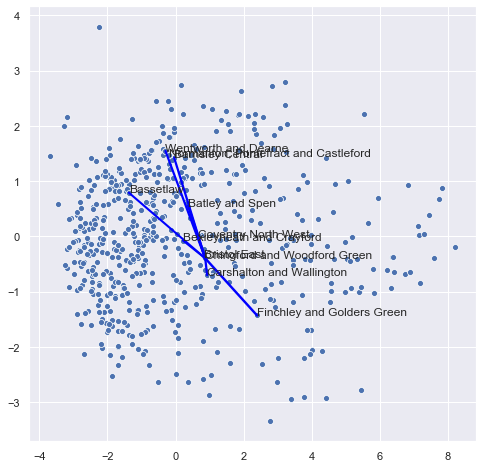

In [73]:
#coi = name_to_id['Chingford and Woodford Green']
significance_matrix = calc_significance_matrix(demographic_data, scores['uns'])
centre_i = id_to_index[coi]
contributions = significance_matrix[centre_i]

# coi = constits of interest
cois = [coi]
linexs = []
lineys = []
values = []

N = 10
for i in np.flip(np.argsort(np.abs(contributions))[-N:]):
    onsid = demographic_data.index[i]
    cois += [onsid]
    values += [contributions[i]]
    #print(contributions[i],id_to_name[onsid,election_results[year]])

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE
embedding = Isomap(n_components=2)
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)

X = demographic_data#[mask]
X_transformed = embedding.fit_transform(preprocessing.scale(X))
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])

for c in cois:
    linexs += [ [x[centre_i],x[id_to_index[c]] ] ]
    lineys += [ [y[centre_i],y[id_to_index[c]] ] ]
    
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y)
#values = preprocessing.scale(values)
for linex,liney,value in zip(linexs,lineys,values):
    plt.plot(linex,liney,linewidth=value, color='blue')

val = pd.Series([id_to_name[i] for i in X.index])
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)

for c in cois:
    ax.text(x[id_to_index[c]], y[id_to_index[c]], id_to_name[c])
    #ax.text(point['x']+.001, point['y'], str(point['val']))

In [ ]:
swing = pd.concat([ scores['uns'],demographic_data],axis=1, verify_integrity=True, sort=True)

In [ ]:
swing.head()

In [ ]:
sns.scatterplot(x=swing['uns'],y=swing['c11Unemployed'])

In [ ]:
print(np.mean(scores['uns'].loc[marginals]))
sns.distplot(scores['uns'].loc[marginals])

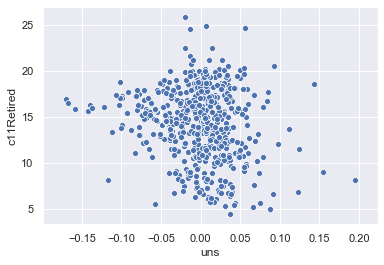

In [79]:
sns.scatterplot(x=scores['uns'].loc[constits_id],y=census['c11Retired'].loc[constits_id])

In [85]:
import requests
url = "https://mycampaignmap.com/graphql/"
params = {
    "query": "{\
        constituencies {\
            id\
            name\
            volunteerNeedBand\
            events {\
                properties {\
                    name\
                    startTime\
                }\
            }\
        }\
    }"
}
r = requests.get(url, params)
data = r.json()["data"]
print('done')

done


14.16607548692125 [5.84752104] 0.017892879377186643
14.16607548692125 5.847521040772358 0.017892879377186643


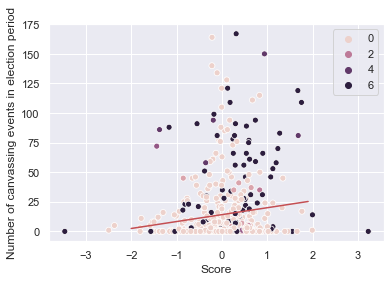

In [147]:
swing = []
n_of_events = []
color = []
result = []
for constit in results.index:
    count = 0
    for j in data['constituencies']:
        if j['id'] == constit:
            for event in j['events']:
                if any(word in event['properties']['name'].lower() for word in 
                      ['canvassing','canvasing']):
                    if (   ('2019-11' == (event['properties']['startTime'][0:7]))
                        or ('2019-12' == (event['properties']['startTime'][0:7]))):
                        count += 1
                    #print(event)
            break
    n_of_events += [count]
    result += [results.loc[constit, 'uns_rescale_normal']]
    swing += [ scores.loc[constit, 'uns']- 0.079 ] 
    color += [j['volunteerNeedBand']]
    #color += [ election_results[year].loc[constit,'winner']]

sns.scatterplot(x=result, y=n_of_events, hue=color)
            
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result).reshape(-1,1)
y = n_of_events
lr.fit(X,y)
print(lr.intercept_,lr.coef_,lr.score(X,y))

x_fit = np.arange(-2, 2, 0.1)
y_fit = lr.intercept_ + x_fit*lr.coef_

ax = sns.lineplot(x_fit,y_fit,color='r')
plt.xlabel('Score')
plt.ylabel('Number of canvassing events in election period')
print(lr.intercept_,float(lr.coef_),lr.score(X,y))

In [82]:
local = pd.read_csv('data/local2019.csv')

,EXTRACT_DATE,ORGANISATION_URI,ORGANISATION_LABEL,SERVICE_TYPE_URI,SERVICE_TYPE_LABEL,ELECTION_DATE,ELECTION_TYPE,AREA_NAME,FULL_NAME,FORENAME,MIDDLE_NAME,SURNAME,PARTY_NAME,VOTES,ELECTED,PAPERS_ISSUED,PAPERS_REJECTED
0,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Calder,"Atkinson, Joe William",Joe,William,Atkinson,Conservative Party,624,NaN,NaN,82
1,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Brighouse,"Atkinson, Kim",Kim,NaN,Atkinson,Green Party,317,NaN,NaN,22
2,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Warley,"Baker, James Douglas",James,Douglas,Baker,Liberal Democrats,1877,Elected,NaN,44
3,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Ovenden,"Bamforth, Sean",Sean,NaN,Bamforth,Liberal Democrats,249,NaN,NaN,38
4,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Skircoat,"Barnes, Mike",Mike,NaN,Barnes,Labour & Co-operative Party,1725,Elected,NaN,26
5,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Elland,"Bashir, bash",bash,NaN,Bashir,Liberal Democrats,486,NaN,NaN,56
6,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Illingworth and Mixenden,"Beech, Guy",Guy,NaN,Beech,Conservative Party,803,NaN,NaN,33
7,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Brighouse,"Benton, Scott Lloyd",Scott,Lloyd,Benton,Conservative Party,1910,Elected,NaN,22
8,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Ovenden,"Booth, David",David,NaN,Booth,Green Party,155,NaN,NaN,38
9,03/05/2019,http://opendatacommunities.org/id/metropolitan...,Calderdale,http://id.esd.org.uk/service/721,Election results,02/05/2019,Local,Hipperholme and Lightcliffe,"Butterick, Keith John",Keith,John,Butterick,Labour Party,676,NaN,NaN,63
